### Import the required libraries

In [31]:
import hydra
from omegaconf import DictConfig
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx
import random
from mlflow import MlflowClient
import sys
sys.path.append('..')

### Initialize the hydra object
The following cell initializes the hydra object by telling it that:
1. All the configs are stored in the folder <kbd>configs</kbd>.
2. Within the folder <kbd>configs</kbd>, it should look into the yaml file <kbd>config.yaml</kbd> for further instructions

Please note following is the way to initialize hydra object in jupyter noteboook. To do this in vs code editor, you will have to do

In [32]:
model_name = 'gcn'
with hydra.initialize(version_base=None, config_path="../configs"):
    cfg = hydra.compose(config_name='config', overrides=[f'model={model_name}'])
    cfg.logger.experiment_name = "test"
    cfg.logger.run_name = f"{model_name}_test"

#### MLflow set up
In the following cell, we create an MLflowClient to test whether an experiment with the same name exists or not, and notify the user.

In [33]:
# Create a MLflow client object with the tracking URI same as the one in the config
client = MlflowClient(tracking_uri=cfg.logger.tracking_uri)
# Get the experiment name and run name from the config
experiment_name = cfg.logger.experiment_name
run_name = cfg.logger.run_name
# Check if an experiment with the same name already exists
experiment = client.get_experiment_by_name(experiment_name)
if experiment: # If the experiment exists
    print (f"Experiment with name \"{experiment_name}\" already exists")

Experiment with name "test" already exists


#### Instantiate the source code

1. Within the app folder, we have defined 2 subfolders - model and data
2. While model contains the source for model-related modules (e.g.: MLP, GCN), data contains the source code to define the data-related modules (e.g.: CORA, MNIST).
3. The default parameters of their source code is defined in configs > model > *.yaml and configs > data > *.yaml
4. The yaml files also contain the path to the source code (check out the first line ```_target_```)
5. In the following cell, we instantiate the source code (in other words we initialize an object of the 2 classes and use the default parameters to initialize them)

In [34]:
# Initialize the model object
model_obj = hydra.utils.instantiate(cfg.model)

# Initialize the data object
cora_dataset = hydra.utils.instantiate(cfg.data)

#### Prepare/download data
Once you have intialized the datamodule, it's time to prepare the data (in other words download the data). Therefore, we call the function prepare_data(). Please note that you don't have to call this function if you were to just do the ML because the trainer method below takes care of that by itself. But we call this function here since we want to visualize the graph.

In [35]:
cora_dataset.prepare_data()
graph = cora_dataset.data[0]

#### Visualize the graph
In this step, we visualize the graph by defining some functions that help us do so.

/tmp/ipykernel_1529/2832839476.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


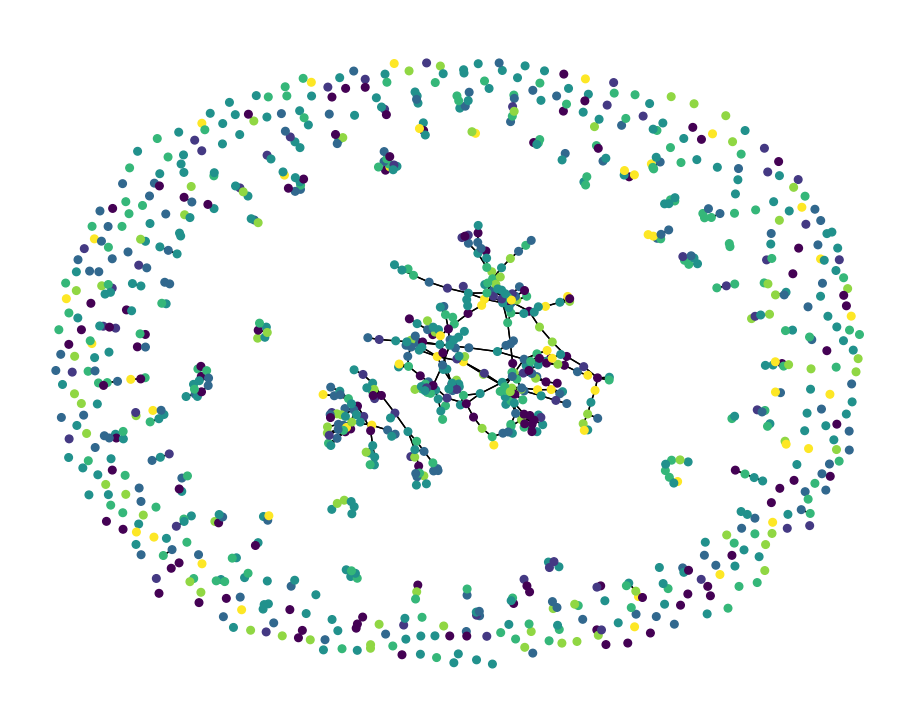

In [36]:
def convert_to_networkx(graph, n_sample=None):
    '''
    A method that takes in the graph and converts it
    into networkx format
    '''
    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):
    '''
    Plot tht networkx graph
    '''
    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    # plt.show()
    plt.savefig("graph.png")

# conver the graph into nextworkx format
g, y = convert_to_networkx(graph, n_sample=1000)
# plot the graph in networkx format
plot_graph(g, y)

#### Initialize the trainer

Once we have initialized the model and data, and visualized the graph (optional), we will now initialize the trainer. Please note that for the trainer, we don't need to write source code. We can just directly use the code provided by lightning (check out ```_target``` of configs > trainer > default.yaml). If you are unfamiliar with trainer, please checkout its description on lightning's website.

In [37]:
trainer = hydra.utils.instantiate(cfg.trainer, logger=cfg.logger)
trainer.logger.log_hyperparams({'data': cfg.data,
                                'model': cfg.model,
                                'trainer': cfg.trainer})
experiment_id = trainer.logger.experiment_id

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Save artifacts
Now that the trainer is initialized, the experiment and run have been logged into MLflow. You can henceforth use the trainer object to access the logger (e.g. save artifacts)

In [38]:
# Extract the run id
run_id = trainer.logger.run_id
# Log the artifact graph.png
# replace graph.png with the path to the image/file you want to log
trainer.logger.experiment.log_artifact(run_id, "graph.png")

#### Fit the trainer using the model and data

Please note that in case of the CORA dataset, pytorch library has already masked values of the data into ```train```, ```val```, and ```test```. We just need to inform the model about these masks. Checkout the method ```model_step``` in the model code.

Therefore, we can provide the same data to both train_loader and val_loader, and let the model code figure out itself.

In [39]:
trainer.fit(model=model_obj, datamodule=cora_dataset)


  | Name       | Type             | Params
------------------------------------------------
0 | conv1      | GCNConv          | 22.9 K
1 | conv2      | GCNConv          | 119   
2 | criterion  | CrossEntropyLoss | 0     
3 | train_loss | MeanMetric       | 0     
4 | val_loss   | MeanMetric       | 0     
5 | test_loss  | MeanMetric       | 0     
------------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.092     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 14.36it/s, v_num=38fe]

`Trainer.fit` stopped: `max_epochs=100` reached.


train loss: 1.1288747787475586
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 13.18it/s, v_num=38fe]


In [40]:
# get test_loss
print (trainer.test(model=model_obj, datamodule=cora_dataset))

Testing: |          | 0/? [00:00<?, ?it/s]

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 54.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0347048044204712
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 1.0347048044204712}]
